In [1]:
import numpy as np
import astra
import tomopy
import pylops
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

import imwip

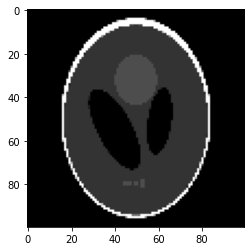

In [2]:
n_frames = 51
im_size = 100
shepp = tomopy.shepp2d(im_size)[0].astype(np.float32)/255
plt.imshow(shepp, cmap="gray")

Modelling the motion using a ZoomingOperator2D:

$
x =
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{bmatrix}
=
\begin{bmatrix}
A(s_1) \\
A(s_2) \\
\vdots \\
A(s_n)
\end{bmatrix}x_1
$

In [3]:
true_scales = 1 - 0.2 * np.sin(np.linspace(0, 5*np.pi, n_frames))

# motion operator
A = lambda si: imwip.AffineWarpingOperator2D((im_size, im_size), scale=si)
M = lambda s: pylops.VStack([A(si) for si in s])

In [4]:
true_x = M(true_scales) @ shepp.ravel()

Display true_x as animation

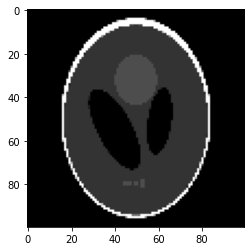

In [5]:
fig, ax = plt.subplots()
camera = Camera(fig)
for frame in np.split(np.clip(true_x, 0, 1), n_frames):
    ax.imshow(frame.reshape((im_size, im_size)), cmap="gray")
    camera.snap()
HTML(camera.animate().to_html5_video())

CT system (astra)

In [6]:
angles = np.linspace(0, np.pi, n_frames)
split_angles = np.split(angles, n_frames)

vol_geom = astra.create_vol_geom(im_size, im_size)

n_det = int(1.25*im_size)
proj_ids = []
for i in range(0, n_frames):
    proj_geom = astra.create_proj_geom('parallel', 1, n_det, split_angles[i])
    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
    proj_ids.append(proj_id)

The full dynamic CT system becomes

$
\begin{bmatrix}
W_1 & 0 & \cdots & 0 \\
0 & W_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & W_n
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{bmatrix}
=
\begin{bmatrix}
p_1 \\
p_2 \\
\vdots \\
p_n
\end{bmatrix}
$

or in short

$
Wx=p
$

In [7]:
W = pylops.BlockDiag([astra.OpTomo(proj_id) for proj_id in proj_ids])

(-0.5, 124.5, 50.5, -0.5)

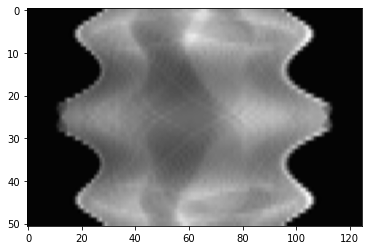

In [8]:
p = W @ true_x
plt.imshow(p.reshape((-1, n_det)), cmap="gray")
plt.axis('auto')

We cannot solve

$
Wx=p
$

for $x$, as this is highly underdetermined.

Instead, we can solve

$
WM(s)x_1=p
$

simultaniously for $s$ and $x_1$
by minimizing

$ f(s, x) = \frac{1}{2}\lVert WM(s)x-p \rVert^2$

In [9]:
# objective function
def obj_f(x, s):
    res = W @ M(s) @ x - p
    return 1/2 * np.dot(res, res)

More important for the solver is the gradient of this objective function:

$
\begin{aligned}
\nabla_x f(s, x) &= M(s)^T&W^T(WM(s)x-p)\\
\nabla_{s} f(s, x) &= \left(\frac{d}{ds} M(s)x\right)^T&W^T(WM(s)x-p)
\end{aligned}
$

In [10]:
# gradient of objective function
def grad_f(x, s):
    WTres = W.T @ (W @ M(s) @ x - p)
    grad_x = M(s).T @ WTres
    grad_s = imwip.diff(M(s), x, to="zoom").T @ WTres
    return grad_x, grad_s

In [11]:
# initial guess: zeros for the image, ones for the scales
s0 = np.ones(n_frames)
x0 = np.zeros(im_size**2, dtype=np.float32)

In [12]:
# solve
x, s = imwip.split_barzilai_borwein(
    grad_f,
    x0=(x0, s0),
    bounds=((0, 1), None),
    max_iter=350,
    verbose=True)

100%|█████████████████████████████████████████| 350/350 [00:28<00:00, 12.15it/s]


Display solution x as video

In [13]:
animated_x = M(s) @ x

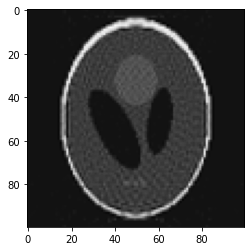

In [14]:
fig, ax = plt.subplots()
camera_solution = Camera(fig)
for frame in np.split(animated_x, n_frames):
    ax.imshow(frame.reshape((im_size, im_size)), cmap="gray")
    camera_solution.snap()
HTML(camera_solution.animate().to_html5_video())